# Working with Textgrids

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import phonlab as phon
from IPython.display import Audio
import seaborn as sns

import importlib  # needed to get example audio/textgrids from package

print(phon.__name__,phon.__version__)

phonlab 0.0.24


## a. Recall this example audio file

* We'll compute a formants dataframe for it now at this step
* And we'll save it as a csv file.
* You can do this "compute and save" step once before tinkering with other analyses

In [2]:
example_audio = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'im_twelve.wav'
x, fs = phon.loadsig(example_audio)
fmtdf = phon.track_formants(x,fs,method='ifc',speaker=2)

fmtdf.to_csv("im_twelve.csv",index=False)  # here's a new thing - save a pandas dataframe as a csv file.

Audio(x,rate=fs)

IFC_tracking(), using method ifc, with speaker set to 2, and pitch range [63, 400]
Resampling from 48000 to 12000
 done         


### Exercise

Find the .csv file on your computer and open it

## b. Well, there is also a TextGrid file for this wav file.

* Read two of the tiers from the TextGrid as a phones dataframe (phdf) and a words dataframe (wddf)
* Merge the pbones and words into a dataframe, representing the data in the TextGrid file
* Drop the word onset and offset times
* Add columns for the preceeding and following phones with phon.add_context()

In [8]:
example_tg = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'im_twelve.TextGrid'

phdf, wddf = phon.tg_to_df(example_tg, tiersel=['phone', 'word'])

phdf.head()

,t1,t2,phone
0,0.000000,0.035047,sp
1,0.035047,0.126541,ay
2,0.126541,0.213045,m
3,0.213045,0.361099,t
4,0.361099,0.398940,w


In [11]:
tgdf = phon.merge_tiers(inner_df=phdf, outer_df=wddf, suffixes=['', '_wd'])
tgdf = tgdf.drop(columns=['t1_wd','t2_wd'])  # don't need to keep the times from the word tier

tgdf = phon.add_context(tgdf, 'phone', nprev = 1, nnext = 1)  # add columns for preceeding and following phone

tgdf.head()

,t1,t2,prev_phone1,phone,next_phone1,word
0,0.000000,0.035047,,sp,ay,sp
1,0.035047,0.126541,sp,ay,m,I'm
2,0.126541,0.213045,ay,m,t,I'm
3,0.213045,0.361099,m,t,w,twelve
4,0.361099,0.398940,t,w,eh,twelve


### Exercise

* use phdf.head() to look at the 'phone' tier before it gets merged.
* Tinker with the add_context() function to add preceeding and following word
* Tinker with the add_context() function to add the two preceeding phones instead of just one


## c. Select measurement points

We will take a subset of the dataframe - so we are just looking at vowels, then we will specify some timepoints in each vowel for which we plan to take measurements.

* df.query() to get a subset of observations based on a test
* phon.explode_intervals() to choose observation points between intervals on a tier

In [12]:
vowels = ['ay', 'eh', 'iy', 'aa', 'aw']
vdf = tgdf.query(f'phone in {vowels}').copy()  # make a dataframe that just has vowels
vdf = phon.explode_intervals([0.2,0.5, 0.8], ts=['t1', 't2'], df=vdf) # get times for observations
vdf['vowel_dur'] = vdf['t2'] - vdf['t1']  # add a vowel duration column

vdf.head()

,t1,t2,prev_phone1,phone,next_phone1,word,obs_t,obs_id,vowel_dur
1,0.035047,0.126541,sp,ay,m,I'm,0.053346,0.2,0.091494
1,0.035047,0.126541,sp,ay,m,I'm,0.080794,0.5,0.091494
1,0.035047,0.126541,sp,ay,m,I'm,0.108243,0.8,0.091494
5,0.398940,0.574179,w,eh,l,twelve,0.433988,0.2,0.175238
5,0.398940,0.574179,w,eh,l,twelve,0.48656,0.5,0.175238


### Exercise

* Convert the vowel duration measurements to milliseconds.
* Create a "consonants" dataframe
* How would you add a column to record a segmental feature, like 'diphthong'?


In [20]:
### ------ HINT  ----------
# see the file phoneclass.csv for a feature definition, we can use pandas merge() to 
#   add that info to the textgrid dataframe

phclass = pd.read_csv('phoneclass.csv')
with_features = tgdf.merge(phclass, on='phone', how='left').fillna('None')

with_features.head()

,t1,t2,prev_phone1,phone,next_phone1,word,majclass
0,0.000000,0.035047,,sp,ay,sp,None
1,0.035047,0.126541,sp,ay,m,I'm,vowel
2,0.126541,0.213045,ay,m,t,I'm,nasal
3,0.213045,0.361099,m,t,w,twelve,stop
4,0.361099,0.398940,t,w,eh,twelve,glide


## d. Merge formant measurements with TextGrid info

* we saw already how we can save a dataframe to a csv file with df.to_csv()
* we will also use pd.read_csv() to read the csv back into a dataframe
* Use the formants calculated and saved earlier
* Merge the formant dataframe with the textgrid dataframe
  

In [13]:
fmtsdf = pd.read_csv('im_twelve.csv')  # read in the csv of formants measurements

vdf = phon.interpolate_measures(
    meas_df=fmtsdf[['sec','F1', 'F2', 'F3', 'F4']],  # meas_ts and cols to interpolate only
    meas_ts='sec',        # time index in the measurements dataframe
    interp_df=vdf,       # textgrid dataframe
    interp_ts='obs_t',  # target observation times in the textgrid
    overwrite=True
)
vdf.head()

,t1,t2,prev_phone1,phone,next_phone1,word,obs_t,obs_id,vowel_dur,F1,F2,F3,F4
1,0.035047,0.126541,sp,ay,m,I'm,0.053346,0.2,0.091494,1066.727492,1562.431293,3033.848950,4079.504079
1,0.035047,0.126541,sp,ay,m,I'm,0.080794,0.5,0.091494,806.738528,1640.668990,2951.169515,4083.634228
1,0.035047,0.126541,sp,ay,m,I'm,0.108243,0.8,0.091494,1040.933010,1844.811223,3067.423593,4068.511502
5,0.398940,0.574179,w,eh,l,twelve,0.433988,0.2,0.175238,835.799529,1618.176045,2840.972875,4290.350547
5,0.398940,0.574179,w,eh,l,twelve,0.48656,0.5,0.175238,765.131866,1529.874403,2971.521694,4274.640150


## e. Visualize formants at vowel measurement points

<Axes: xlabel='Time (sec)', ylabel='Frequency (Hz)'>

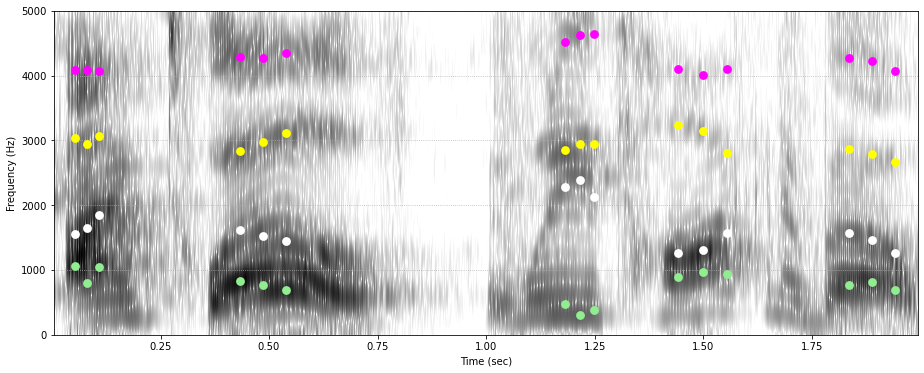

In [12]:
phon.sgram(x,fs,tf=5000)

sns.pointplot(vdf,x='obs_t',y='F1',linestyle='none',native_scale=True,marker="o",color='lightgreen')
sns.pointplot(vdf,x='obs_t',y='F2',linestyle='none',native_scale=True,marker="o",color='white')
sns.pointplot(vdf,x='obs_t',y='F3',linestyle='none',native_scale=True,marker="o",color='yellow')
sns.pointplot(vdf,x='obs_t',y='F4',linestyle='none',native_scale=True,marker="o",color='magenta')



## f. A quick little demonstration of how to use deltaF vowel normalization

1256.7346060780105


(1.0, 0.2)

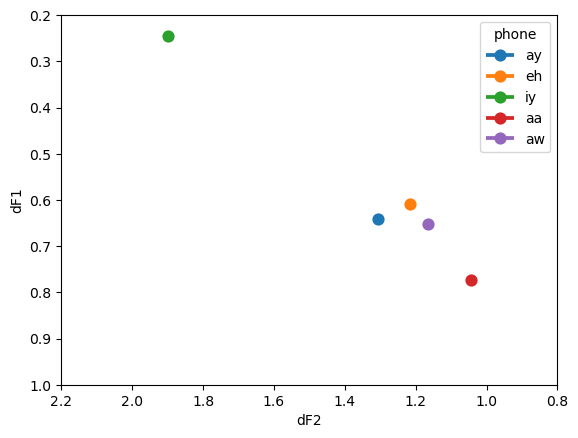

In [13]:
deltaf = np.mean([[vdf['F1']/0.5],[vdf['F2']/1.5], [vdf['F3']/2.5], [vdf['F4']/3.5]])
print(deltaf)
vdf['dF1'] = vdf['F1']/deltaf
vdf['dF2'] = vdf['F2']/deltaf
vdf['dF3'] = vdf['F3']/deltaf

fig,ax = plt.subplots()
sns.pointplot(vdf.loc[vdf.obs_id==0.5],x='dF2',y='dF1',native_scale=True, hue="phone",linestyles = "dashed", ax=ax)
ax.set_xlim(2.2,0.8)
ax.set_ylim(1,0.2)